In [1]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input, concatenate,Lambda,GaussianNoise
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [2]:
#MountainCarContinuous-v0
#Pendulum-v0
#BipedalWalker-v2
#LunarLanderContinuous-v2 env._max_episode_steps=2000
#Acrobot-v1
env=gym.make("Pendulum-v0")
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

# REINFORCE with linear approximators

In [3]:
class REINFORCE(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.alpha_mu=paras['alpha_mu']
        self.paras_mu=np.zeros((self.dim_state,self.num_action))
        self.alpha_sigma=paras['alpha_sigma']
        self.paras_sigma=np.zeros((self.dim_state,self.num_action))
        self.gamma=0.999

    def pi(self,s,a):
        mu=self.get_mu(s)
        sigma=self.get_sigma(s)
        pi=np.exp(0.5*((mu-a)/(sigma))**2)/(sigma*np.sqrt(2*np.pi))
        return pi
        
    def get_mu(self,s):
        return s.dot(self.paras_mu)
    
    def get_sigma(self,s):
        return np.exp(s.dot(self.paras_sigma))
    
    def get_actions(self,s):
        mu=self.get_mu(s)
        sigma=self.get_sigma(s)
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a
        
    def update_paras(self,states,actions,rewards):
        T=len(states)
        rewards=np.array(rewards)
        rewards=(rewards-rewards.min()+1e-10)/(rewards.max()-rewards.min()+1e-10)
        for t in range(T):
            G=sum([rewards[k]*(self.gamma**(k-t-1)) for k in range(t+1,T)])
            a=actions[t]
            s=states[t]
            prob=self.pi(s,a)
            mu=self.get_mu(s)
            sigma=self.get_sigma(s)
            
            d_mu=s.reshape(-1,1).dot(((1/sigma**2)*(a-mu)).reshape(1,-1))
            d_sigma=s.reshape(-1,1).dot(((((a-mu)/sigma)**2)-1).reshape(1,-1))
            
            self.paras_mu+=self.alpha_mu*(self.gamma**t)*G*d_mu
            self.paras_sigma+=self.alpha_sigma*(self.gamma**t)*G*d_sigma

50 -19.950736006891162
100 -8.421883439131285
150 -9.579695302780996
200 -9.38472208761539


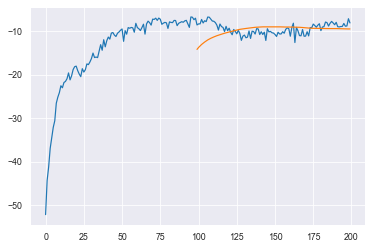

In [4]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['alpha_mu']=1e-5
agent_config['alpha_sigma']=1e-5
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent=REINFORCE(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        a = agent.get_actions(s)
        sp, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = sp
        G+=r
    G_log.append(G)
    agent.update_paras(states,actions,rewards)
    
    if (epoch+1)%50==0:
        print(epoch+1,np.mean(G_log[-50:]))
plt.plot(G_log)
plt.plot(pd.DataFrame(G_log).rolling(100).mean())
plt.show()            

# REINFORCE with nonlinear approximators

In [5]:
class approximator(nn.Module):
    def __init__(self,paras):
        super(approximator, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_policy=paras['alpha_policy']
        self.structure_policy=paras['structure_policy']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_policy[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
        self.structure.append([nn.Linear(self.structure_policy[-1],self.output_dim),nn.Linear(self.structure_policy[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_policy)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

In [6]:
class REINFORCE_NN(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.approximator=approximator(paras)
    
    def get_actions(self,s):
        mu,sigma=self.approximator.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,states,actions,rewards):
        G=np.array([sum([rewards[k]*(self.gamma**(k-t-1)) for k in range(t+1,len(states))]) for t in range(len(states))])
        s=np.array([list(states[idx][0]) for idx in range(len(states))])
        a=np.array([list(actions[idx][0]) for idx in range(len(actions))])        
        gammas=np.array([self.gamma**t for t in range(len(states))])
        G*=gammas
        G=(G-G.min()+1e-10)/(G.max()-G.min()+1e-10)
        
        mu,sigma=self.approximator.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        G = T.tensor(G, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.approximator_loss = -log_probs*G
        self.approximator.optimizer.zero_grad()
        self.approximator_loss.sum().backward()
        self.approximator.optimizer.step()

50 -41.11634554536104


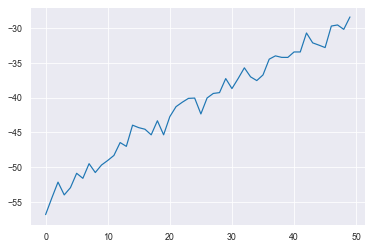

100 -21.83667897969204


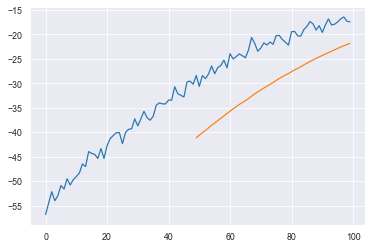

150 -15.069217135083086


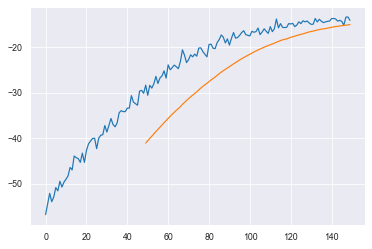

200 -13.332129579239304


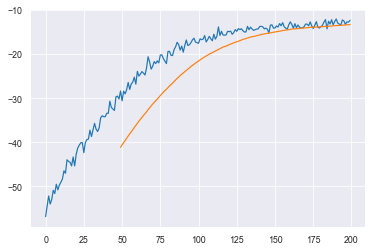

In [7]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_policy']=1e-3
agent_config['structure_policy']=[64,32]
agent=REINFORCE_NN(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a)
        states.append(s.reshape(1,-1))
        actions.append(a)
        rewards.append(r)
        s = sp
        G+=r
    G_log.append(G)
    agent.update_paras(states,actions,rewards)
    if (epoch+1)%50==0:
        print(epoch+1,np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

# REINFORCE with nonlinear approximators & baseline

In [8]:
class approximator_baseline(nn.Module):
    def __init__(self,paras):
        super(approximator_baseline, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_policy=paras['alpha_policy']
        self.structure_policy=paras['structure_policy']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_policy[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
        self.structure.append([nn.Linear(self.structure_policy[-1],self.output_dim),nn.Linear(self.structure_policy[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_policy)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

In [9]:
class REINFORCE_baseline_NN(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.approximator=approximator_baseline(paras)
        self.baseline=self.get_baseline(paras)
        
    def get_baseline(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(paras['structure_baseline']):
            if idx==0:
                dense_layers = [Dense(layer, activation='relu')(state)]
            else:
                dense_layers.append(Dense(layer, activation='relu')(dense_layers[-1]))
        value = Dense(1, activation='linear')(dense_layers[-1])
        baseline = Model(input=[state], output=[value])
        baseline.compile(optimizer=Adam(lr=paras['alpha_baseline']), loss="mse")
        return baseline
    
    def get_actions(self,s):
        mu,sigma=self.approximator.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,states,actions,rewards):
        G=np.array([sum([rewards[k]*(self.gamma**(k-t-1)) for k in range(t+1,len(states))]) for t in range(len(states))])
        s=np.array([list(states[idx][0]) for idx in range(len(states))])
        a=np.array([list(actions[idx][0]) for idx in range(len(actions))])        
        gammas=np.array([self.gamma**t for t in range(len(states))])
        v_s=self.baseline.predict(s)
        G=(G-G.min()+1e-10)/(G.max()-G.min()+1e-10)
        delta=G.reshape(-1,1)-v_s
        self.baseline.fit(s,delta,verbose=False)
        
        delta=delta.T
        delta*=gammas
        mu,sigma=self.approximator.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        delta = T.tensor(delta, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.approximator_loss = -log_probs*delta
        self.approximator.optimizer.zero_grad()
        self.approximator_loss.sum().backward()
        self.approximator.optimizer.step()
        
        

50 -45.14301134983666


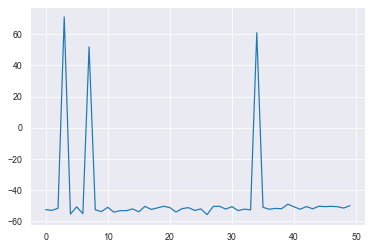

100 -45.052250282392535


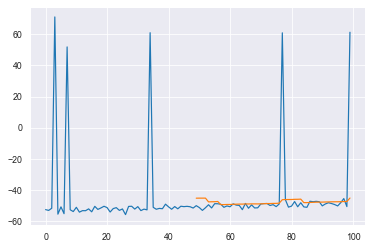

150 -44.93389418155221


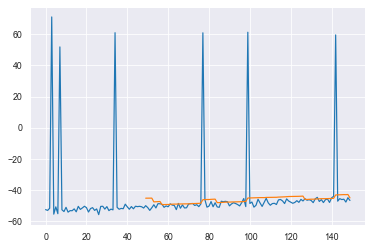

200 -42.15988622790896


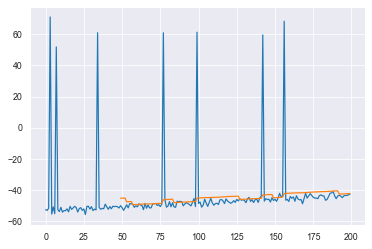

In [11]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_policy']=1e-5
agent_config['structure_policy']=[256,128]
agent_config['alpha_baseline']=1e-3
agent_config['structure_baseline']=[256,128]


agent=REINFORCE_baseline_NN(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a)
        states.append(s.reshape(1,-1))
        actions.append(a)
        rewards.append(r)
        s = sp
        G+=r
    G_log.append(G)
    agent.update_paras(states,actions,rewards)
    if (epoch+1)%50==0:
        print(epoch+1,np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

# Actor-Critic

In [12]:
class Actor(nn.Module):
    def __init__(self,paras):
        super(Actor, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_actor=paras['alpha_actor']
        self.structure_actor=paras['structure_actor']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_actor[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
        self.structure.append([nn.Linear(self.structure_actor[-1],self.output_dim),nn.Linear(self.structure_actor[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_actor)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

class AC(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.actor=Actor(paras)
        self.critic=self.Critic(paras)
        
    def Critic(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(paras['structure_critic']):
            if idx==0:
                dense_layers = [Dense(layer, activation='relu')(state)]
            else:
                dense_layers.append(Dense(layer, activation='relu')(dense_layers[-1]))
        value = Dense(1, activation='linear')(dense_layers[-1])
        critic = Model(input=[state], output=[value])
        critic.compile(optimizer=Adam(lr=paras['alpha_critic']), loss="mse")
        return critic
    
    def get_actions(self,s):
        mu,sigma=self.actor.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,s,a,r,sp,done,gamma):
        v_s=self.critic.predict(s)
        v_sp=self.critic.predict(sp)
        target=r+self.gamma*v_sp*(not done)
        delta=target-v_s
        self.critic.fit(s,target,verbose=False)
        
        delta*=gamma
        mu,sigma=self.actor.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        delta = T.tensor(delta, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.actor_loss = -log_probs*delta
        self.actor.optimizer.zero_grad()
        self.actor_loss.sum().backward()
        self.actor.optimizer.step()

In [ ]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=1e-7
agent_config['structure_actor']=[256,128]
agent_config['alpha_critic']=1e-5
agent_config['structure_critic']=[256,128]
agent=AC(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    gamma=1
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a[0])
        agent.update_paras(s.reshape(1,-1),a,r,sp.reshape(1,-1),done,gamma)
        gamma*=agent.gamma
        s = sp
        G+=r
    G_log.append(G)
    print(G)
    if (epoch+1)%10==0:
        print(epoch+1,np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

# DDPG

In [3]:
class DDPG(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.update_weights(self.target_actor,self.actor)
        
        
        self.critic=self.Critic(paras)
        self.target_critic=self.Critic(paras,Target=True)
        self.update_weights(self.target_critic,self.critic)
        
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.polyak=paras['polyak']
        self.count=0
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done):
        self.memory.append([s,a,r,sp,done])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
    
    def sample_exp(self):
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.batch_size),replace=False)
        return np.array(self.memory)[index_set]
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp=self.sample_exp()
            s=np.array([list(_) for _ in sampled_exp[:,0]])
            a=np.array([list(_) for _ in sampled_exp[:,1]])
            r=sampled_exp[:,2].reshape(-1,1)
            sp=np.array([list(_) for _ in sampled_exp[:,3]])
            done=sampled_exp[:,4].reshape(-1,1)
            self.update_paras(s,a,r,sp,done)
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            sigma=self.sigma
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_weights(self,update_target,update_source,polyak=0):
        old_weight=update_target.get_weights()
        new_weight=update_source.get_weights()
        weight=[polyak*old_weight[idx]+(1-polyak)*new_weight[idx] for idx in range(len(new_weight))]
        update_target.set_weights(weight)
        
    def update_paras(self,s,a,r,sp,done):
        mup=self.target_actor.predict(sp)
        Q_sp_ap=self.target_critic.predict([sp,mup])
        target=r+self.gamma*Q_sp_ap*(1-done)
        mu=self.actor.predict(s)
        self.critic.fit([s,a],target,verbose=False) 
        
        
        d_mu=self.get_grad([s,mu])[0]
        self.actor.fit(s,mu+d_mu,verbose=False) 
        
        self.update_weights(self.target_actor,self.actor,self.polyak)
        self.update_weights(self.target_critic,self.critic,self.polyak)
        

1 -1503.421623763639 [4.] 200
2 -1503.926087796299 [4.] 400
3 -1501.4373194452446 [4.] 600
4 -1252.8058673244861 [4.] 800
5 -1491.366436339758 [4.] 1000
6 -1188.4044977451338 [4.] 1200
7 -1160.959866643792 [4.] 1400
8 -1097.6339602527173 [4.] 1600
9 -1518.3626709568832 [4.] 1800
10 -1589.7923202823943 [4.] 2000
10 -1380.8110650550348


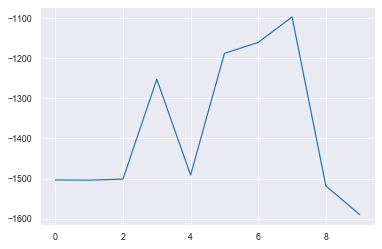

11 -1502.5050726239049 [4.] 2200
12 -1183.2990625621705 [4.] 2400
13 -1075.104261436523 [4.] 2600
14 -1246.8313455135249 [4.] 2800
15 -1193.7509993568335 [4.] 3000
16 -1511.6836998732708 [4.] 3200
17 -1522.580012243149 [4.] 3400
18 -1615.3540908783423 [4.] 3600
19 -1505.778225246972 [4.] 3800
20 -1355.496476515158 [4.] 4000
20 -1376.0246948400102


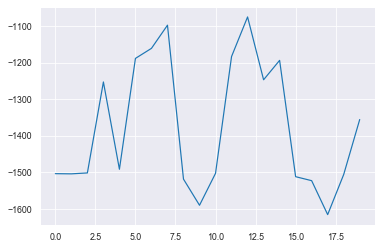

21 -1368.6543538550577 [4.] 4200
22 -1513.3229811826902 [4.] 4400
23 -1576.5857713758392 [4.] 4600
24 -972.6721692693062 [4.] 4800
25 -1294.218336795064 [4.] 5000
26 -1494.2037741642848 [4.] 5200
27 -1610.8806722864442 [4.] 5400
28 -1554.1943963390345 [4.] 5600
29 -1365.8767975375424 [4.] 5800
30 -1043.817526959053 [4.] 6000
30 -1377.1640225521505


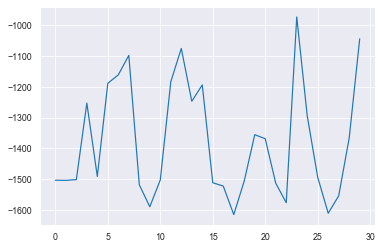

31 -1591.474588697202 [4.] 6200
32 -950.9657510810154 [4.] 6400
33 -1506.8747449165007 [4.] 6600
34 -1575.2956264727013 [4.] 6800
35 -1390.8848546667189 [4.] 7000
36 -1493.645467400889 [4.] 7200
37 -1622.4199320234484 [4.] 7400
38 -1623.1616804022717 [4.] 7600
39 -1164.0734672785147 [4.] 7800
40 -1623.512295635252 [4.] 8000
40 -1396.4307271284756


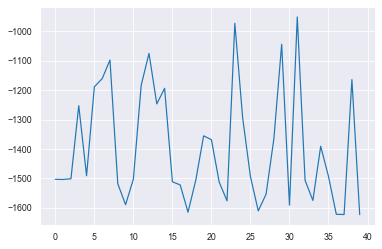

41 -960.7900333665591 [4.] 8200
42 -1545.953482914053 [4.] 8400
43 -1618.5713155312592 [4.] 8600
44 -1489.6188848495863 [4.] 8800
45 -1099.9801042048941 [4.] 9000
46 -1335.037663126841 [4.] 9200
47 -1254.7064962295622 [4.] 9400
48 -1511.4568477474236 [4.] 9600
49 -1619.523697377329 [4.] 9800
50 -1226.137698633092 [3.996] 10000
50 -1390.3801061823926


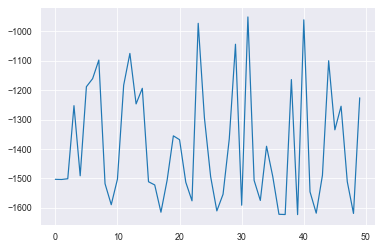

51 -1154.267560038173 [3.2713287] 10200
52 -1279.6835714884076 [2.6780767] 10400
53 -1579.5199495136385 [2.1924098] 10600
54 -1677.815329440906 [1.7948194] 10800
55 -1479.397100005966 [1.4693302] 11000
56 -1496.1927478546756 [1.202869] 11200
57 -1343.7871894694692 [0.98472947] 11400
58 -1541.63221404517 [0.80614966] 11600
59 -1291.9344590592825 [0.65995526] 11800
60 -1554.7384507064053 [0.5402731] 12000
60 -1402.1972646038275


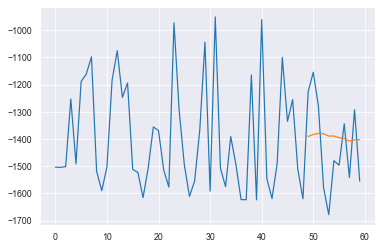

61 -989.3544521066548 [0.44229522] 12200
62 -1612.030723938596 [0.36208537] 12400
63 -1630.0573728596485 [0.29642162] 12600
64 -1632.8155036647595 [0.24266596] 12800
65 -1604.1831298260975 [0.19865876] 13000
66 -1638.1406901875525 [0.1626322] 13200
67 -1303.9844990221745 [0.13313898] 13400
68 -1248.5567177879784 [0.1089944] 13600
69 -403.9099201889328 [0.08922836] 13800
70 -945.494082994847 [0.07304686] 14000
70 -1388.1201415303753


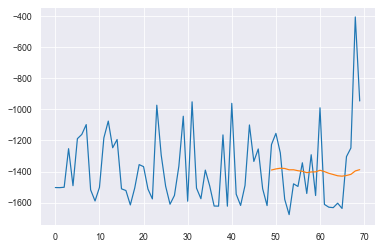

71 -271.9204682433081 [0.05979986] 14200
72 -1385.12862446608 [0.04895522] 14400
73 -135.1735168356065 [0.04007723] 14600
74 -938.377215199106 [0.03280927] 14800
75 -388.9504573533961 [0.02685933] 15000
76 -380.35681509184883 [0.02198842] 15200
77 -1475.954934346131 [0.01800085] 15400
78 -1059.1457431495157 [0.01473642] 15600
79 -252.85801216648375 [0.01206399] 15800
80 -2.9272520973377936 [0.0098762] 16000
80 -1238.0474667140654


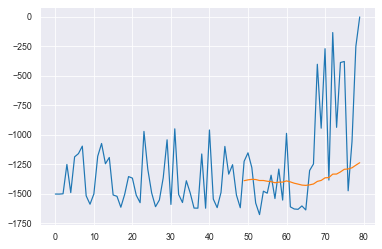

81 -1495.8578449741951 [0.00808515] 16200
82 -1250.5743306893655 [0.00661892] 16400
83 -1354.8091293470604 [0.00541858] 16600
84 -1575.6911996646552 [0.00443593] 16800
85 -0.8620702674490289 [0.00363148] 17000
86 -1649.7438255526838 [0.00297291] 17200
87 -2.4196947675389566 [0.00243378] 17400
88 -119.01259410080274 [0.00199241] 17600
89 -19.06622801892526 [0.00163109] 17800
90 -250.62749891189156 [0.00133529] 18000
90 -1101.5745868684662


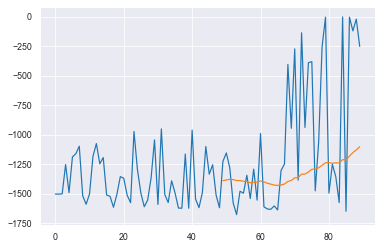

91 -124.50106561470248 [0.00109314] 18200
92 -119.6812881580185 [0.0008949] 18400
93 -232.9267503745306 [0.00073261] 18600
94 -130.6884521223485 [0.00059975] 18800
95 -1383.3536062762148 [0.00049099] 19000
96 -132.68595058908554 [0.00040195] 19200
97 -397.4225781729622 [0.00032905] 19400
98 -787.1901466720212 [0.00026938] 19600
99 -896.2655682516679 [0.00022053] 19800
100 -940.6023200425428 [0.00018054] 20000
100 -931.2454169143363


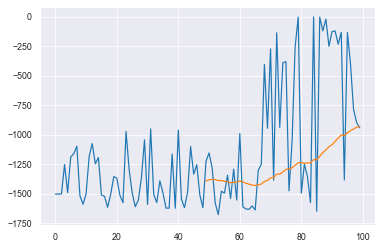

101 -917.9265491205359 [0.0001478] 20200
102 -900.2446503093414 [0.00012099] 20400
103 -876.6512783683502 [9.905144e-05] 20600
104 -970.0272258440382 [8.1088576e-05] 20800
105 -958.195677298787 [6.638322e-05] 21000
106 -974.5490262010178 [5.434466e-05] 21200
107 -967.1924220529704 [4.448929e-05] 21400
108 -965.959163559384 [3.642119e-05] 21600
109 -852.5480172503388 [2.981625e-05] 21800
110 -826.6849899061683 [2.4409093e-05] 22000
110 -827.4656254801131


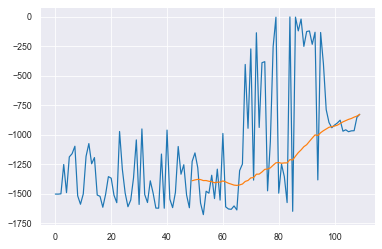

111 -478.79733455525474 [1.9982537e-05] 22200
112 -739.3895745247352 [1.6358732e-05] 22400
113 -370.899080268125 [1.3392086e-05] 22600
114 -331.93548040468545 [1.0963444e-05] 22800
115 -115.83519880732901 [1.e-05] 23000
116 -119.79197196330482 [1.e-05] 23200
117 -235.037764514893 [1.e-05] 23400
118 -235.11232413878827 [1.e-05] 23600
119 -130.49486782436932 [1.e-05] 23800
120 -128.75867853395405 [1.e-05] 24000
120 -625.0161291392769


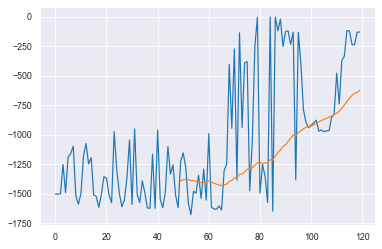

121 -128.6873634256079 [1.e-05] 24200
122 -235.13739300230446 [1.e-05] 24400
123 -597.8246418213537 [1.e-05] 24600
124 -365.8620322175308 [1.e-05] 24800
125 -367.0421660210956 [1.e-05] 25000
126 -374.3426576283988 [1.e-05] 25200
127 -235.36891842293267 [1.e-05] 25400
128 -366.9554725328004 [1.e-05] 25600
129 -363.8593829321265 [1.e-05] 25800
130 -122.89698415385477 [1.e-05] 26000
130 -562.3598086034608


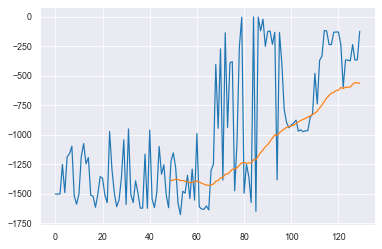

131 -122.86108733877153 [1.e-05] 26200
132 -357.2146548356255 [1.e-05] 26400
133 -124.7926568022441 [1.e-05] 26600
134 -122.12735199703943 [1.e-05] 26800
135 -377.01256379609686 [1.e-05] 27000
136 -137.54524460446981 [1.e-05] 27200
137 -502.3048052964723 [1.e-05] 27400
138 -453.12832115118283 [1.e-05] 27600
139 -481.41235770984144 [1.e-05] 27800
140 -490.97595472898644 [1.e-05] 28000
140 -471.37402024278396


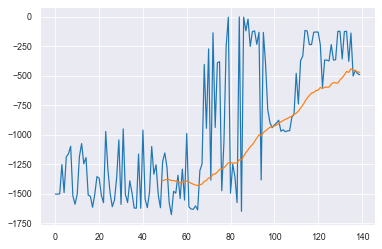

141 -492.42262868346444 [1.e-05] 28200
142 -362.25360572599885 [1.e-05] 28400
143 -663.1142270205364 [1.e-05] 28600
144 -252.3625101972069 [1.e-05] 28800
145 -263.8563838564415 [1.e-05] 29000
146 -722.8501982788127 [1.e-05] 29200
147 -649.7889465493391 [1.e-05] 29400
148 -620.7712055158645 [1.e-05] 29600
149 -764.6223012658703 [1.e-05] 29800
150 -613.4200863524535 [1.e-05] 30000
150 -476.57690758622186


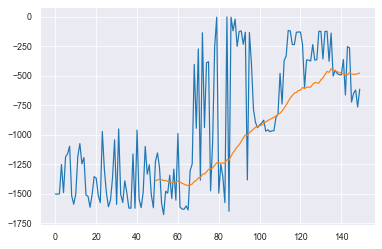

151 -254.69436746310896 [1.e-05] 30200
152 -601.8465934184272 [1.e-05] 30400
153 -483.9435527786147 [1.e-05] 30600
154 -369.44230623640294 [1.e-05] 30800
155 -740.3775598987417 [1.e-05] 31000
156 -624.0330765953901 [1.e-05] 31200
157 -252.85189550837464 [1.e-05] 31400
158 -482.0409161960115 [1.e-05] 31600
159 -243.25403781543994 [1.e-05] 31800
160 -388.4062800075891 [1.e-05] 32000
160 -381.1951393063653


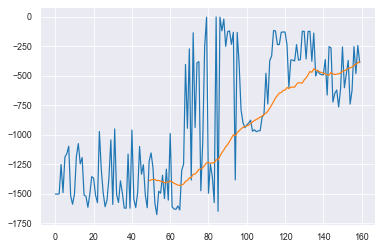

161 -366.27682370239035 [1.e-05] 32200
162 -9.793398969696225 [1.e-05] 32400
163 -361.64320033139137 [1.e-05] 32600
164 -121.69007492038243 [1.e-05] 32800
165 -124.20536024648038 [1.e-05] 33000
166 -117.80542459158532 [1.e-05] 33200
167 -123.93484370739084 [1.e-05] 33400
168 -121.34374758058192 [1.e-05] 33600
169 -125.95351347940655 [1.e-05] 33800
170 -251.0116974376104 [1.e-05] 34000
170 -357.9472554949948


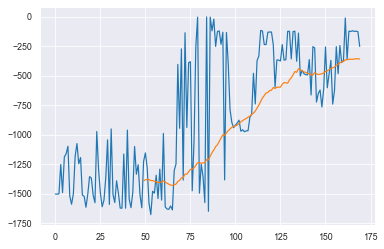

171 -239.60827951344115 [1.e-05] 34200
172 -260.97703090089624 [1.e-05] 34400
173 -123.26035706402037 [1.e-05] 34600
174 -242.9781559835662 [1.e-05] 34800
175 -121.7438210152827 [1.e-05] 35000
176 -124.58878776166485 [1.e-05] 35200
177 -237.74095395934336 [1.e-05] 35400
178 -245.1851646805789 [1.e-05] 35600
179 -117.96725857331315 [1.e-05] 35800
180 -117.30911009115302 [1.e-05] 36000
180 -331.41489364269984


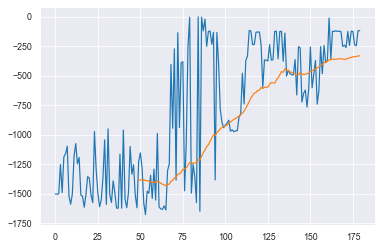

181 -124.50278372575482 [1.e-05] 36200
182 -237.4207104614524 [1.e-05] 36400
183 -0.6880536606371156 [1.e-05] 36600
184 -117.63625840846056 [1.e-05] 36800
185 -221.83962695777404 [1.e-05] 37000
186 -121.11768630894744 [1.e-05] 37200
187 -124.44244579219009 [1.e-05] 37400
188 -120.22653473739607 [1.e-05] 37600
189 -247.68798910381193 [1.e-05] 37800
190 -251.53133413225711 [1.e-05] 38000
190 -299.36926214325894


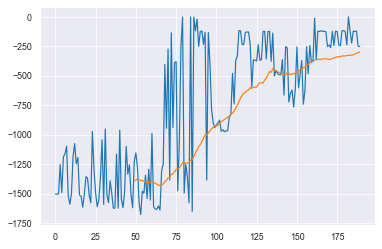

191 -123.44114236046106 [1.e-05] 38200
192 -241.99667968540902 [1.e-05] 38400
193 -346.5857661667075 [1.e-05] 38600
194 -117.04866967769523 [1.e-05] 38800
195 -118.05164408380311 [1.e-05] 39000
196 -114.20603831768807 [1.e-05] 39200
197 -118.46974193774969 [1.e-05] 39400
198 -118.5835004789362 [1.e-05] 39600
199 -119.93881707466824 [1.e-05] 39800
200 -128.64705547565057 [1.e-05] 40000
200 -222.19940137951454


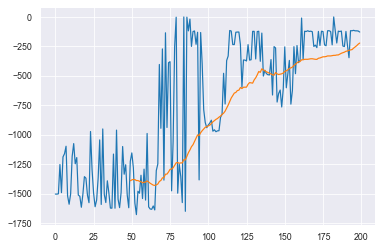

201 -122.55464491055616 [1.e-05] 40200
202 -2.5863776481011547 [1.e-05] 40400
203 -249.55940848791997 [1.e-05] 40600
204 -366.7180753107322 [1.e-05] 40800
205 -249.18214978525629 [1.e-05] 41000
206 -123.63541315460277 [1.e-05] 41200
207 -232.72291581445313 [1.e-05] 41400
208 -127.06162435443831 [1.e-05] 41600
209 -128.12333615027396 [1.e-05] 41800
210 -130.64809278161067 [1.e-05] 42000
210 -168.0374304291114


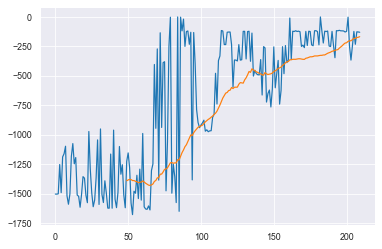

211 -123.33796379338463 [1.e-05] 42200
212 -119.74731876807324 [1.e-05] 42400
213 -123.8407067117332 [1.e-05] 42600
214 -130.1939762874968 [1.e-05] 42800
215 -127.95799970377115 [1.e-05] 43000
216 -124.88806098982599 [1.e-05] 43200
217 -129.707677257308 [1.e-05] 43400
218 -121.29098889080316 [1.e-05] 43600
219 -262.6920698131652 [1.e-05] 43800
220 -8.809180389104071 [1.e-05] 44000
220 -159.0135875818664


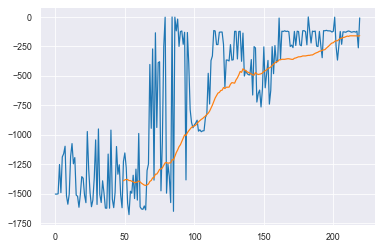

221 -247.22260506218123 [1.e-05] 44200
222 -129.59381206423393 [1.e-05] 44400
223 -131.3910314431726 [1.e-05] 44600
224 -129.61182999788727 [1.e-05] 44800
225 -124.0958473813095 [1.e-05] 45000
226 -131.3921249920886 [1.e-05] 45200
227 -10.933172097970427 [1.e-05] 45400
228 -355.1499491331167 [1.e-05] 45600
229 -132.74224389938863 [1.e-05] 45800
230 -258.1138647389787 [1.e-05] 46000
230 -155.39133880720777


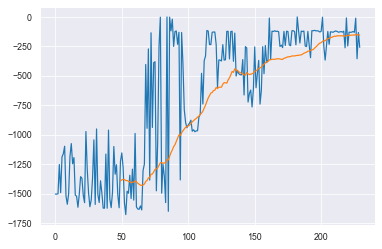

231 -245.67561816635083 [1.e-05] 46200
232 -133.28389741864618 [1.e-05] 46400
233 -251.41457110749295 [1.e-05] 46600
234 -120.36533219462268 [1.e-05] 46800
235 -243.7778207941018 [1.e-05] 47000
236 -236.3542184737679 [1.e-05] 47200
237 -121.87995092076613 [1.e-05] 47400
238 -8.865990253971647 [1.e-05] 47600
239 -242.42251016749177 [1.e-05] 47800
240 -131.83172576878198 [1.e-05] 48000
240 -158.766903046754


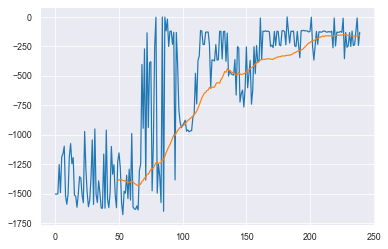

241 -127.2295312606583 [1.e-05] 48200
242 -344.9342940316727 [1.e-05] 48400
243 -126.72432498970026 [1.e-05] 48600
244 -2.2730075240999583 [1.e-05] 48800
245 -239.54851645829146 [1.e-05] 49000
246 -1.61164669210591 [1.e-05] 49200
247 -304.405642514709 [1.e-05] 49400
248 -236.53692810554017 [1.e-05] 49600
249 -231.80214346415238 [1.e-05] 49800
250 -0.6442098081422274 [1.e-05] 50000
250 -160.1417268385601


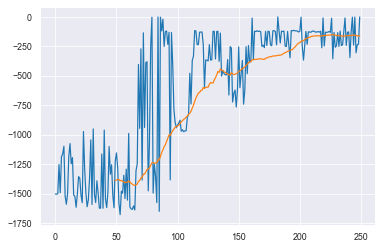

251 -230.91847608783775 [1.e-05] 50200
252 -118.65929168841744 [1.e-05] 50400
253 -235.34341030179803 [1.e-05] 50600
254 -0.5175441501098971 [1.e-05] 50800
255 -128.2043956247371 [1.e-05] 51000
256 -125.45364073404082 [1.e-05] 51200
257 -127.25753268172113 [1.e-05] 51400
258 -254.22567853413577 [1.e-05] 51600
259 -118.5969761628213 [1.e-05] 51800
260 -117.58895751502561 [1.e-05] 52000
260 -154.62120414021408


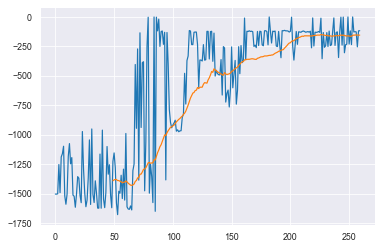

261 -3.309398493812587 [1.e-05] 52200
262 -128.47587633089378 [1.e-05] 52400
263 -123.29923315049635 [1.e-05] 52600
264 -237.83598584521056 [1.e-05] 52800
265 -119.5277302398306 [1.e-05] 53000
266 -234.53685846069448 [1.e-05] 53200
267 -236.91715561853363 [1.e-05] 53400
268 -228.357293322521 [1.e-05] 53600
269 -119.56781519616115 [1.e-05] 53800
270 -245.7307203924845 [1.e-05] 54000
270 -162.72304662913356


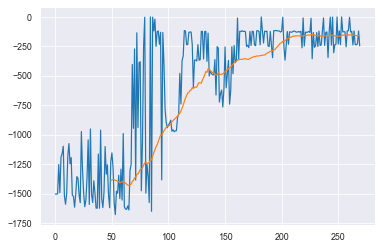

271 -128.2869916687675 [1.e-05] 54200
272 -121.96166430883228 [1.e-05] 54400
273 -1.6969770418671122 [1.e-05] 54600
274 -120.43530484095044 [1.e-05] 54800
275 -119.3022651940335 [1.e-05] 55000
276 -228.0856010763411 [1.e-05] 55200
277 -2.176810401782388 [1.e-05] 55400
278 -238.20159166913413 [1.e-05] 55600
279 -229.2757246561868 [1.e-05] 55800
280 -118.70364488077344 [1.e-05] 56000
280 -155.88064852770037


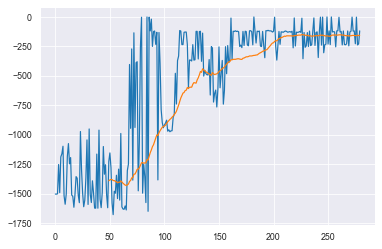

281 -245.18382419147875 [1.e-05] 56200
282 -227.18429241252468 [1.e-05] 56400
283 -117.26492326074383 [1.e-05] 56600
284 -248.62942631842546 [1.e-05] 56800
285 -264.46511842681633 [1.e-05] 57000
286 -122.55452476870983 [1.e-05] 57200
287 -1.6501517830108516 [1.e-05] 57400
288 -121.2152678435875 [1.e-05] 57600
289 -124.69216186704887 [1.e-05] 57800
290 -255.6633565347485 [1.e-05] 58000
290 -155.73327677052237


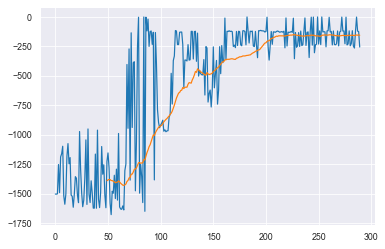

291 -115.21723160029426 [1.e-05] 58200
292 -118.70917080560386 [1.e-05] 58400
293 -244.40332943306117 [1.e-05] 58600
294 -117.03240899528548 [1.e-05] 58800
295 -120.33762341704565 [1.e-05] 59000
296 -117.0693379213497 [1.e-05] 59200
297 -125.00174557179528 [1.e-05] 59400
298 -243.0018569810581 [1.e-05] 59600
299 -239.82467148354064 [1.e-05] 59800
300 -239.99364995333735 [1.e-05] 60000
300 -157.03089239678837


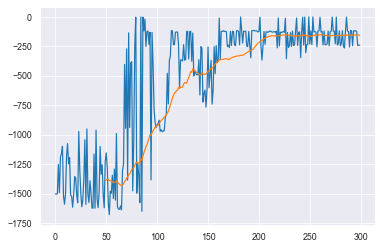

In [6]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99

agent_config['pure_explore_step']=10000
agent_config['start_learning_step']=5000

agent=DDPG(agent_config)

Iter=300
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    while not done:
        a = agent.get_actions(s.reshape(1,-1))[0]
        sp, r, done, info = env.step(a)
        agent.memorize(s,a,r,sp,done)
        agent.learn()
        s = sp
        G+=r
    G_log.append(G)
    print(len(G_log),G,agent.sigma,len(agent.memory))
    if (epoch+1)%10==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()  

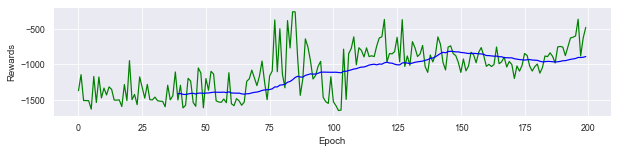

In [5]:
plt.figure(figsize=(10,2))
plt.plot(G_log,c="green")
plt.plot(pd.DataFrame(G_log).rolling(int(len(G_log)/5)).mean(),c="blue")
plt.xlabel("Epoch")
plt.ylabel("Rewards")
plt.show()

# TD3: Twin Delayed DDPG

In [9]:
class TD3(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.update_weights(self.target_actor,self.actor)
        
        self.critic_1=self.Critic(paras)
        self.critic_2=self.Critic(paras)
        self.target_critic_1=self.Critic(paras,Target=True)
        self.target_critic_2=self.Critic(paras,Target=True)
        self.update_weights(self.target_critic_1,self.critic_1)
        self.update_weights(self.target_critic_2,self.critic_2)
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.polyak=paras['polyak']
        self.count=0
        self.Q_update_count=0
        self.policy_delay=paras['policy_delay']
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done):
        self.memory.append([s,a,r,sp,done])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
    
    def sample_exp(self):
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.batch_size),replace=False)
        return np.array(self.memory)[index_set]
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp=self.sample_exp()
            s=np.array([list(_) for _ in sampled_exp[:,0]])
            a=np.array([list(_) for _ in sampled_exp[:,1]])
            r=sampled_exp[:,2].reshape(-1,1)
            sp=np.array([list(_) for _ in sampled_exp[:,3]])
            done=sampled_exp[:,4].reshape(-1,1)
            self.update_paras(s,a,r,sp,done)
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),self.sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_weights(self,update_target,update_source,polyak=0):
        old_weight=update_target.get_weights()
        new_weight=update_source.get_weights()
        weight=[polyak*old_weight[idx]+(1-polyak)*new_weight[idx] for idx in range(len(new_weight))]
        update_target.set_weights(weight)
        
    
    def update_paras(self,s,a,r,sp,done):
        mup=self.target_actor.predict(sp)
        ap=mup+np.random.normal(np.zeros(self.num_action),self.sigma)  
        ap=np.clip(ap,self.lower_bound_action,self.upper_bound_action)

        Q_sp_ap_1=self.target_critic_1.predict([sp,ap])
        Q_sp_ap_2=self.target_critic_2.predict([sp,ap])
        
        Q_sp_ap=np.zeros((len(s),2))
        Q_sp_ap[:,0]=Q_sp_ap_1.reshape(-1,1)[:,0]
        Q_sp_ap[:,1]=Q_sp_ap_2.reshape(-1,1)[:,0]
        Q_sp_ap=np.min(Q_sp_ap,axis=1).reshape(-1,1)
        
        target=r+self.gamma*Q_sp_ap*(1-done)
        self.critic_1.fit([s,a],target,verbose=False) 
        self.critic_2.fit([s,a],target,verbose=False) 
        
        self.update_weights(self.target_critic_1,self.critic_1,self.polyak)
        self.update_weights(self.target_critic_2,self.critic_2,self.polyak)
        self.Q_update_count+=1
        
        if self.Q_update_count%self.policy_delay==0:
            mu=self.actor.predict(s)
            d_mu=self.get_grad([s,mu])[0]
            self.actor.fit(s,mu+d_mu,verbose=False) 
            self.update_weights(self.target_actor,self.actor,self.polyak)
            


In [7]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99

agent_config['pure_explore_step']=10000
agent_config['start_learning_step']=5000
agent_config['policy_delay']=2


agent=TD3(agent_config)

Iter=500
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    while not done:
        a = agent.get_actions(s.reshape(1,-1))[0]
        sp, r, done, info = env.step(a)
        agent.memorize(s,a,r,sp,done)
        agent.learn()
        s = sp
        G+=r
    G_log.append(G)
    print(len(G_log),G,agent.sigma,len(agent.memory))
    if (epoch+1)%10==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()  

NameError: name 'TD3' is not defined